# Curso de CNN con PyTorch

<img src="https://yaelmanuel.com/wp-content/uploads/2021/12/platzi-banner-logo-matematicas.png" width="500px">

---

## Creando nuestro propio Clasificador de Imágenes 👀😷

En este lab aprenderás:

* [Pytorch](https://pytorch.org/)
* [Torchvision](https://pytorch.org/vision/stable/index.html)
* Descargar un dataset, prepararlo, entrenarlo, realizar finetuning y guardarlo.


### 1) Cargar el dataset 🤓

**Tenemos 2 formas:**

**1)** Cargar el dataset arrastrando el .zip hacia el notebook.

In [7]:
#!unzip "labeled-chest-xray-images.zip"

**2)** Guardar el .zip en Google Drive y luego darle permisos al notebook para que pueda accederlo.

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

### 2) Preparación de la data 👌

#### 2.1) Instalamos las dependencias 🙌

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

#### 2.2) Tips de implementación 👀

In [10]:
cudnn.benchmark = True

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 2.3) Data Augmentation 📷 📸

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### 2.4) Dataset, Dataloader y más data 🔍

In [13]:
data_dir = '/content/chest_xray'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

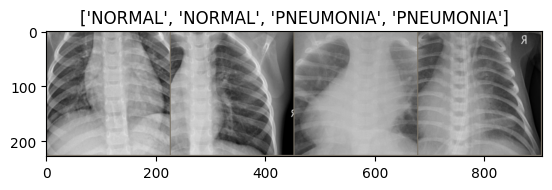

In [14]:
def imshow(inp, title=None):
    """Imshow para tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pausarlo un poco para que se actualicen los plots


# Obtener un batch de datos de entrenamiento
inputs, classes = next(iter(dataloaders['train']))

# Crear una grilla con las imágenes
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

***Evaluar las class_names***

In [15]:
print(class_names)

['NORMAL', 'PNEUMONIA']


### 3) Finetuning de la convnet 😨

#### 1) Definir capa tras capa de nuestra CNN

Para este caso es una estructura estrictamente secuencial.

##### CNN 1

In [16]:
layers = [
    # Bloque conv → ReLU → pool
    nn.Conv2d(3, 4, kernel_size=3, padding=1),    # De 3 canales (RGB) a 4 mapas de características
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                           # Pooling reduce a la mitad la resolución

    # Aplanar y FCs (Capas fully-connected)
    nn.Flatten(),
    nn.Linear(4 * 112 * 112, 2)                   # Asume entrada 224×224 → tras pooling 112×112
]

#### 2) Montar el Sequential

In [17]:
model_ft = nn.Sequential(*layers)

model_ft = model_ft.to(device)

### 4) Entrenamiento 💪

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada epoch tiene una fase de entrenamiento y validación.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Fase entrenamiento
            else:
                model.eval()   # Fase validación

            running_loss = 0.0
            running_corrects = 0

            # Iterar sobre la data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history solo si es la fase de entrenamiento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize solo si es la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy el modelo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Cargar el best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### **Definir Función de Loss y Optimizador**

In [18]:
criterion = nn.CrossEntropyLoss()

# Observe que todos los parámetros están siendo optimizados
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decae LR por un factor de 0.1 cada 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6212 Acc: 0.7376
val Loss: 0.7013 Acc: 0.6522

Epoch 1/4
----------
train Loss: 0.5639 Acc: 0.7521
val Loss: 0.5865 Acc: 0.6843

Epoch 2/4
----------
train Loss: 0.5386 Acc: 0.7647
val Loss: 0.6482 Acc: 0.6458

Epoch 3/4
----------
train Loss: 0.5168 Acc: 0.7817
val Loss: 0.4977 Acc: 0.7628

Epoch 4/4
----------
train Loss: 0.5704 Acc: 0.7703
val Loss: 0.6917 Acc: 0.6378

Training complete in 6m 13s
Best val Acc: 0.762821


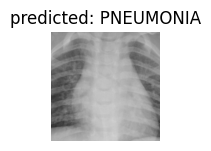

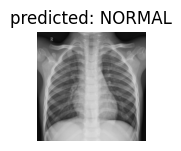

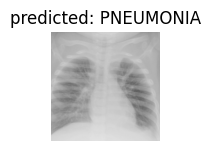

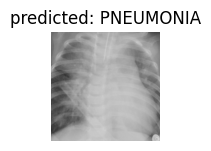

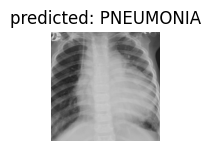

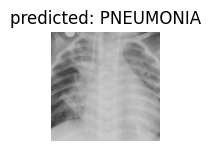

In [22]:
visualize_model(model_ft)

### 5) Guardar el modelo 💾

In [24]:
torch.save(model_ft, "model.pth")

### 6) Hacer Predicciones en Producción 🤙

In [25]:
import torch
from torchvision import transforms
from PIL import Image

Cargar el modelo una vez (al inicio de la aplicación)

In [26]:
# Determinar el dispositivo
mi_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo en el dispositivo
mi_modelo = torch.load("model.pth", map_location=mi_device, weights_only=False)
mi_modelo.eval()
mi_modelo.to(mi_device)

Sequential(
  (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=50176, out_features=2, bias=True)
)

Función para predicción / inferencia

In [27]:
def predict_image(image_path, model, class_names, device):
    """
    Predice la clase de una imagen usando un modelo entrenado.

    Args:
        image_path (str): Ruta de la imagen.
        model (torch.nn.Module): Modelo ya cargado y configurado para inferencia.
        class_names (list): Lista de nombres de clases.
        device (torch.device): Dispositivo donde está el modelo.

    Returns:
        str: Clase predicha.
    """
    # Preprocesamiento de la imagen
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Cargar y preprocesar la imagen
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)  # Añadir dimensión batch y mover al dispositivo

    # Realizar predicción
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)

    # Retornar la clase predicha
    return class_names[preds[0].item()]


Ejemplos de uso

In [28]:
class_names = ['NORMAL', 'PNEUMONIA']

In [29]:
path_image = "/content/chest_xray/val/NORMAL/NORMAL-11419-0001.jpeg"

predicted_class = predict_image(path_image, mi_modelo, class_names, mi_device)
print(f"La clase predicha es: {predicted_class}")

La clase predicha es: NORMAL


In [31]:
path_image = "/content/bacteria.jpeg"

predicted_class = predict_image(path_image, mi_modelo, class_names, mi_device)
print(f"La clase predicha es: {predicted_class}")

La clase predicha es: PNEUMONIA


### 7) Conclusiones

- Aprender sobre los distintos objetos y métodos que nos ofrece Pytorch / Torchvision.

- Realizar el proceso completo de clasificación de imágenes con Pytorch.

- Aprender tips sobre implementación con el uso de la GPU.

<br>
<br>
<br>